## Image Classification using CNN in Pytorch

#### (a) Dataloader Download the MNIST train and test dataset on Canvas. Implement a data loader with batch size and validation size as arguments. (HINT: You can check the documentation here: Creating a Custom Dataset for your files)

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x_train_data = np.load('x_train.npy')
y_train_data = np.load('y_train.npy')
print(x_train_data.shape)

(60000, 784)


In [19]:
# combine the x and y data into a single dataset
class CostumDataset(Dataset):
    def __init__(self, x, y= None):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        # convert the numpy arrays to torch tensors
        # convert the [784] to [1, 28, 28]
        features = torch.tensor(self.x[idx], dtype = torch.float32).reshape(1, 28, 28)
        if self.y is not None:
            label = torch.tensor(self.y[idx], dtype = torch.long)
            return features, label
        else:
            return features


# implement a data loader with batch size and validation size as arguments.
def data_loader(x, y, batch_size = 32, validation_size = 0.2, random_seed = 42):
    data_size = x.shape[0]
    np.random.seed(random_seed)
    # shuffle the data
    indices = np.random.permutation(data_size)
    split = int(np.floor(validation_size * data_size))
    # split the data into training and validation sets
    x_train, x_val = x[indices[split:]], x[indices[:split]]
    y_train, y_val = y[indices[split:]], y[indices[:split]]

    train_loader = DataLoader(CostumDataset(x_train, y_train), batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(CostumDataset(x_val, y_val), batch_size = batch_size)
    return train_loader, val_loader


#### (b) Data Exploration Pick one example from each digit and visualize them. Count the number of samples per digit in the original training data. Is the data distribution balanced?

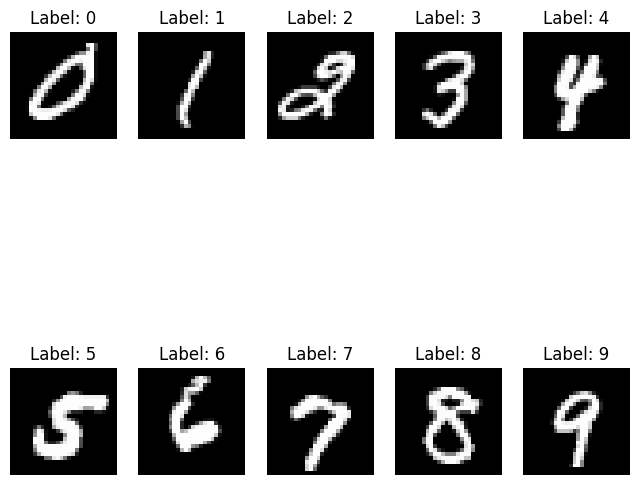

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


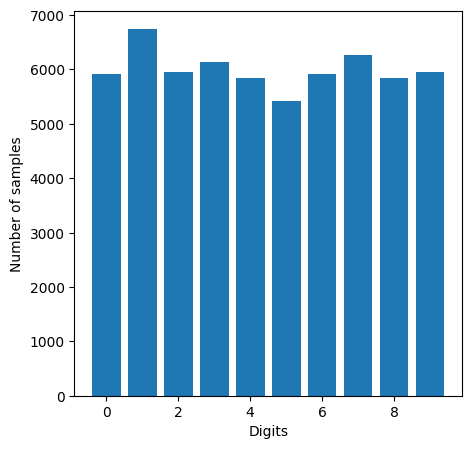

In [20]:
# visualize each digit
def visulize_samples(x, y):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 5, 2
    digits_count = {}
    for i in range(1, cols * rows + 1):
        # count samples label equal to i-1
        indices_label = np.where(y == i-1)[0]
        digits_count[i-1] = len(indices_label)
        sample_idx = np.random.choice(indices_label)
        # reshape the image to 28x28
        img = x[sample_idx].reshape(28, 28)

        ax = figure.add_subplot(rows, cols, i)
        ax.axis('off')
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {i-1}")
    plt.show()
    return digits_count

# plot the number of samples for each digit
def visulize_digits_distribution(digits_count):
    plt.figure(figsize=(5, 5))
    plt.bar(digits_count.keys(), digits_count.values())
    plt.xlabel('Digits')
    plt.ylabel('Number of samples')
    plt.show()

digits_count = visulize_samples(x_train_data, y_train_data)
print(digits_count)
visulize_digits_distribution(digits_count)



**From the bar chart of number of samples for each digit, It can be seen that the distribution is close to uniform, with the number of each number concentrated between 5800 and 6500**

#### (c) Data Split Split original training data into 80% for training and 20% validation datasets.

In [21]:
train_loader, val_loader = data_loader(x_train_data, y_train_data, batch_size = 32, validation_size = 0.2, random_seed = 42)
print(len(train_loader.dataset), len(val_loader.dataset))
print(len(train_loader), len(val_loader))

# only print the first 2 batches
n = 2
for batch, (X, y) in enumerate(train_loader):
    if batch == n:
        break
    print(f"batch#={batch}, X.shape={X.shape}; y.shape={y.shape}")

48000 12000
1500 375
batch#=0, X.shape=torch.Size([32, 1, 28, 28]); y.shape=torch.Size([32])
batch#=1, X.shape=torch.Size([32, 1, 28, 28]); y.shape=torch.Size([32])


#### (d) Modeling Implement a convolutional neural network to classify the digits in the MNIST dataset. Experiment with at least 3 hyperparameters. You may experiment with different CNN hyper-parameters, e.g. num of layers, filter size, stride, activation function, dropout, weight regularization, etc. Use the validation data to decide which combination of hyperparameters is best. Report the final classification accuracy on the validation dataset.

In [22]:
import torch.nn as nn

# convolution block defind
class Cnn_block(nn.Module):
    def __init__(self, in_channels, n_hidden = 5, kernel_size = (2, 2), 
                 stride = 1, bias = False, p=0.2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = n_hidden, 
                      kernel_size = kernel_size, stride = stride, padding='same', bias = bias),
            nn.BatchNorm2d(num_features=n_hidden),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Conv2d(in_channels=n_hidden, out_channels=in_channels, 
                      kernel_size=kernel_size, stride=stride, padding='same', bias=bias),
            nn.BatchNorm2d(num_features=in_channels),
            nn.ReLU(),
            nn.Dropout(p=p)
        )
    
    def forward(self, x):
        # apply residual (x+f(x))
        return x+self.layers(x)

In [23]:
# linear block class
class Linear_block(nn.Module):
    def __init__(self, in_features, n_hidden):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=n_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=n_hidden, out_features=in_features),
            nn.ReLU()
        )
    
    def forward(self, x):
        return x+self.layers(x)

In [24]:
# put convolution block and linear block to build the CNN model
class CNNClassifier(nn.Module):
    def __init__(self, in_channels = 1, n_layers = 3, cnn_channels = 8, linear_hidden=1000, n_class=10, 
                 kernel_size = (3,3), stride = 1, feature_size = 28, p=0.2):
        super().__init__()

        layers = []
        curr_feature_size = feature_size
        for i in range(n_layers):
            out_channels = (i+1) * cnn_channels
            layers.append(Cnn_block(in_channels=in_channels, n_hidden=out_channels, kernel_size=kernel_size, 
                      stride=stride, p=p))
            # if the feature size is greater than 7, apply max pooling
            if curr_feature_size > 7:
                # apply max pooling
                layers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=2))
                curr_feature_size //= 2

        self.cnn_layers = nn.Sequential(*layers)

        output_shape = curr_feature_size * curr_feature_size

        # self.down_sampling = nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=(1, 1))

        self.linear_layers = nn.Sequential(
            Linear_block(output_shape, linear_hidden),
            Linear_block(output_shape, linear_hidden),
        )

        self.last_layer = nn.Linear(output_shape, n_class)

        self.all = nn.Sequential(
            self.cnn_layers,
            # self.down_sampling,
            nn.Flatten(),
            self.linear_layers,
            self.last_layer
        )

    def forward(self, x):
        return self.all(x)

In [25]:
from torch.optim import Adam

# setting the baic hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = CNNClassifier(in_channels=1, n_layers = 5, cnn_channels=8, linear_hidden=100, 
                      kernel_size=(3,3), stride=1, p=0.2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

cuda


In [27]:
from tqdm import tqdm

# train the model
def train(model, train_loader, val_loader, loss_fn, optimizer, n_epochs = 10):
    train_losses = []
    val_losses = []
    train_acc, val_acc = [], []
    for epoch in range(n_epochs):
        model.train()
        epoch_train_loss = []
        train_correct = 0
        train_total = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            train_loss = loss_fn(y_pred, y)
            train_loss.backward()
            optimizer.step()

            epoch_train_loss.append(train_loss.item())

            # calculate the accuracy
            _, y_pred_labels = torch.max(y_pred, dim=1)
            train_total += y.size(0)
            train_correct += (y_pred_labels == y).sum().item()
        
        train_acc.append(100*train_correct/train_total)

        # validation
        model.eval()
        epoch_val_loss = []
        val_correct = 0
        val_total = 0
        for batch, (X, y) in enumerate(val_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            val_loss = loss_fn(y_pred, y)
            epoch_val_loss.append(val_loss.item())

            # calculate the accuracy
            _, y_pred_labels = torch.max(y_pred, dim=1)
            val_total += y.size(0)
            val_correct += (y_pred_labels == y).sum().item()
        
        val_acc.append(100*val_correct/val_total)
        
        train_losses.append(np.mean(epoch_train_loss))
        val_losses.append(np.mean(epoch_val_loss))
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, " 
              f"Train Acc: {train_acc[-1]:.4f}%, Val Acc: {val_acc[-1]:.4f}%")
    
    # print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, " 
    #       f"Train Acc: {train_acc[-1]:.4f}%, Val Acc: {val_acc[-1]:.4f}%")

    return train_losses, val_losses, train_acc, val_acc

train_losses, val_losses, train_acc, val_acc = train(model, train_loader, val_loader, loss_fn, optimizer, n_epochs = 10)

Epoch 1/10, Train Loss: 0.6053, Val Loss: 0.2561, Train Acc: 80.1750%, Val Acc: 92.3667%
Epoch 2/10, Train Loss: 0.2589, Val Loss: 0.1680, Train Acc: 91.6333%, Val Acc: 94.9583%
Epoch 3/10, Train Loss: 0.1985, Val Loss: 0.1583, Train Acc: 93.5604%, Val Acc: 94.8083%
Epoch 4/10, Train Loss: 0.1759, Val Loss: 0.1270, Train Acc: 94.3896%, Val Acc: 96.2167%
Epoch 5/10, Train Loss: 0.1560, Val Loss: 0.1128, Train Acc: 94.9604%, Val Acc: 96.6917%
Epoch 6/10, Train Loss: 0.1470, Val Loss: 0.1126, Train Acc: 95.1479%, Val Acc: 96.5750%
Epoch 7/10, Train Loss: 0.1396, Val Loss: 0.1151, Train Acc: 95.5500%, Val Acc: 96.4750%
Epoch 8/10, Train Loss: 0.1316, Val Loss: 0.1026, Train Acc: 95.6542%, Val Acc: 96.7750%
Epoch 9/10, Train Loss: 0.1287, Val Loss: 0.0984, Train Acc: 95.8896%, Val Acc: 96.9750%
Epoch 10/10, Train Loss: 0.1202, Val Loss: 0.0936, Train Acc: 96.0979%, Val Acc: 97.1167%


**Because the Train Acc is getting when traing, so it is lower than val accuracy**

In [11]:
# find the best cnn hyperparameters
def find_best_parameters(parameters_grid, train_loader, val_loader, 
                         loss_fn, device, optimizer, n_epochs = 10):
    best_accuracy = 0
    best_parameters = {}

    for n_layers in parameters_grid['n_layers']:
        for cnn_channels in parameters_grid['cnn_channels']:
            for linear_hidden in parameters_grid['linear_hidden']:
                for kernel_size in parameters_grid['kernel_size']:
                    for p in parameters_grid['p']:
                        model = CNNClassifier(in_channels=1, n_layers=n_layers, cnn_channels=cnn_channels, 
                                              linear_hidden=linear_hidden, kernel_size=kernel_size, 
                                              stride=1, p=p).to(device)
                        
                        optimizer = Adam(model.parameters(), lr=1e-3)
                        train_losses, val_losses, train_acc, val_acc = train(model, train_loader, val_loader, 
                                                                           loss_fn, optimizer, n_epochs)
                        if val_acc[-1] > best_accuracy:
                            best_accuracy = val_acc[-1]
                            best_parameters = {'n_layers': n_layers, 'cnn_channels': cnn_channels, 
                                              'linear_hidden': linear_hidden, 'kernel_size': kernel_size, 'p': p}
    return best_parameters, best_accuracy
    

In [12]:
# define the hyperparameters grid
parameter_grid = {
    'n_layers': [3, 5, 7],
    'cnn_channels': [8, 16, 32],
    'linear_hidden': [100, 200, 500],
    'kernel_size': [(2, 2), (3, 3), (4, 4)],
    'p': [0.2, 0.3, 0.5]
}

best_parameters, best_accuracy = find_best_parameters(parameter_grid, train_loader, val_loader, loss_fn, 
                                                      device, optimizer, 20)

/home/jianglongyu/Documents/CSCE633/HW4/ml/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


Train Loss: 0.1436, Val Loss: 0.1186, Train Acc: 95.2271%, Val Acc: 96.3833%
Train Loss: 0.1583, Val Loss: 0.1524, Train Acc: 94.7958%, Val Acc: 95.1500%
Train Loss: 0.1930, Val Loss: 0.2051, Train Acc: 93.4313%, Val Acc: 93.4333%
Train Loss: 0.1003, Val Loss: 0.0814, Train Acc: 96.7458%, Val Acc: 97.4583%
Train Loss: 0.1184, Val Loss: 0.1232, Train Acc: 96.1479%, Val Acc: 96.1583%
Train Loss: 0.1556, Val Loss: 0.2130, Train Acc: 95.0187%, Val Acc: 93.9083%
Train Loss: 0.0758, Val Loss: 0.0683, Train Acc: 97.5958%, Val Acc: 97.8583%
Train Loss: 0.0924, Val Loss: 0.0920, Train Acc: 96.9875%, Val Acc: 97.2000%
Train Loss: 0.1163, Val Loss: 0.1219, Train Acc: 96.2146%, Val Acc: 96.4417%
Train Loss: 0.1283, Val Loss: 0.1263, Train Acc: 95.6312%, Val Acc: 95.9583%
Train Loss: 0.1244, Val Loss: 0.1315, Train Acc: 95.8917%, Val Acc: 95.9750%
Train Loss: 0.1704, Val Loss: 0.1763, Train Acc: 94.2583%, Val Acc: 94.2667%
Train Loss: 0.0866, Val Loss: 0.0878, Train Acc: 97.1333%, Val Acc: 97.2917%

In [13]:
print(best_parameters, best_accuracy)

{'n_layers': 7, 'cnn_channels': 32, 'linear_hidden': 500, 'kernel_size': (4, 4), 'p': 0.2} 98.41666666666667


**As you can see, I tried several different parameter to train the model, which include `n_layers`, `cnn_channels`, `linear_hidden`, `kernel_size`, and `drop_rate`. The epoch is 20. So the best accuarcy I get in the val dataset is 98.41%, with parameters "{'n_layers': 7, 'cnn_channels': 32, 'linear_hidden': 500, 'kernel_size': (4, 4), 'p': 0.2}"**

In [17]:
# get the best model
best_model = CNNClassifier(in_channels=1, **best_parameters).to(device)
optimizer = Adam(best_model.parameters(), lr=1e-3)
train_losses, val_losses, train_acc, val_acc = train(best_model, train_loader, val_loader, loss_fn, optimizer, n_epochs = 10)

Epoch 1/10, Train Loss: 0.4742, Val Loss: 0.2136, Train Acc: 84.5646%, Val Acc: 93.4083%
Epoch 2/10, Train Loss: 0.1980, Val Loss: 0.2139, Train Acc: 93.8167%, Val Acc: 93.1250%
Epoch 3/10, Train Loss: 0.1628, Val Loss: 0.1358, Train Acc: 94.7938%, Val Acc: 95.7750%
Epoch 4/10, Train Loss: 0.1404, Val Loss: 0.1498, Train Acc: 95.6188%, Val Acc: 95.3833%
Epoch 5/10, Train Loss: 0.1276, Val Loss: 0.1275, Train Acc: 95.9375%, Val Acc: 95.8917%
Epoch 6/10, Train Loss: 0.1182, Val Loss: 0.0946, Train Acc: 96.3042%, Val Acc: 97.2250%
Epoch 7/10, Train Loss: 0.1070, Val Loss: 0.1066, Train Acc: 96.6104%, Val Acc: 96.7500%
Epoch 8/10, Train Loss: 0.1008, Val Loss: 0.0850, Train Acc: 96.7500%, Val Acc: 97.2583%
Epoch 9/10, Train Loss: 0.0945, Val Loss: 0.0907, Train Acc: 97.0396%, Val Acc: 97.1667%
Epoch 10/10, Train Loss: 0.0929, Val Loss: 0.0855, Train Acc: 97.0979%, Val Acc: 97.3917%


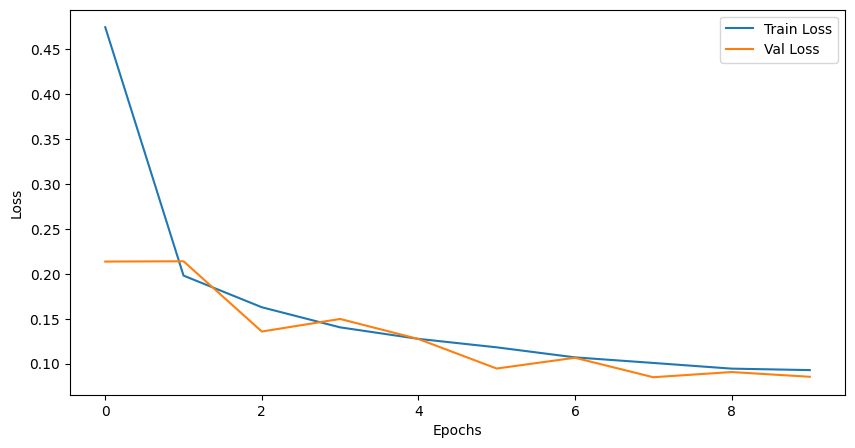

In [18]:
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### (g) Inference Use the best fine-tuned model for inference on the test dataset. Save your predictions for every row of the test data in a CSV file with the name FirstName LastName Preds.csv (Do not shuffle the test data)

In [33]:
import pandas as pd

# get predictions of the test data by the best model
test_data = np.load('x_test.npy')

# process the test data
# for test data, we can set more batch size
test_loader = DataLoader(CostumDataset(test_data), batch_size = 64, shuffle = False)
best_model.eval()

predictions = []
with torch.no_grad():
    for batch, X in enumerate(test_loader):
        X = X.to(device)
        y_pred = best_model(X)
        _, y_pred_labels = torch.max(y_pred, dim=1)
        predictions.extend(y_pred_labels.cpu().numpy())

# save the predictions to a csv file
df = pd.DataFrame({'Preds': predictions})
df.to_csv('Jianglong_Yu_Preds.csv', index=False)


#### BONUS(+10 points): Filter Visualization Randomly pick an image from the training set. Visualize the feature maps corresponding to all convolution filters after the first and last convolution layers.

In [59]:
# create a new model to extract the features
class CNNFeaturesExtractor(nn.Module):
    def __init__(self, model) -> None:
        super().__init__()
        self.first_layer = model.cnn_layers[0]
        self.middle_layers = nn.Sequential(*list(model.cnn_layers[1:-1]))
        self.last_layer = model.cnn_layers[-1]
    
    def forward(self, x):
        x_first = self.first_layer(x)
        x_mid = self.middle_layers(x_first)
        x_last = self.last_layer(x_mid)
        return x_first, x_last

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 7, 7])


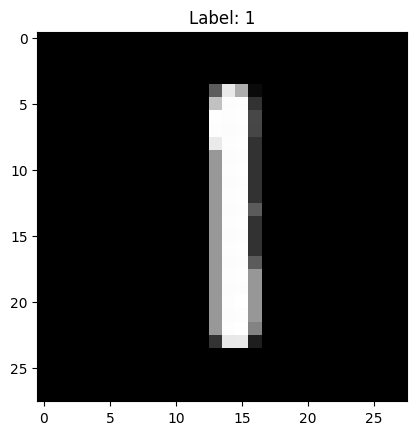

In [80]:
# pick a random image from the train data
random_idx = np.random.randint(0, len(x_train_data))
plt.imshow(x_train_data[random_idx].reshape(28, 28), cmap='gray')
plt.title(f"Label: {y_train_data[random_idx]}")
img = torch.tensor(x_train_data[random_idx], dtype = torch.float32).reshape(1, 1, 28, 28).to(device)

# extract the features
feature_extractor = CNNFeaturesExtractor(best_model)
features_first, features_last = feature_extractor(img)
print(features_first.shape, features_last.shape)


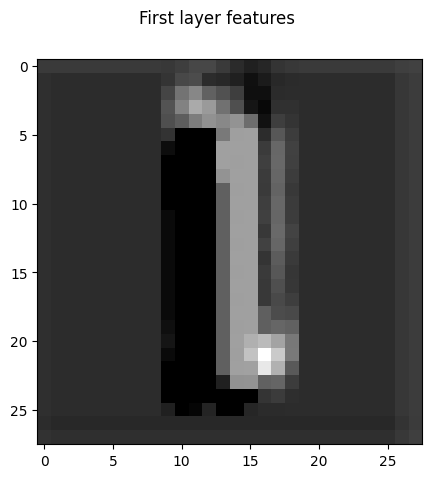

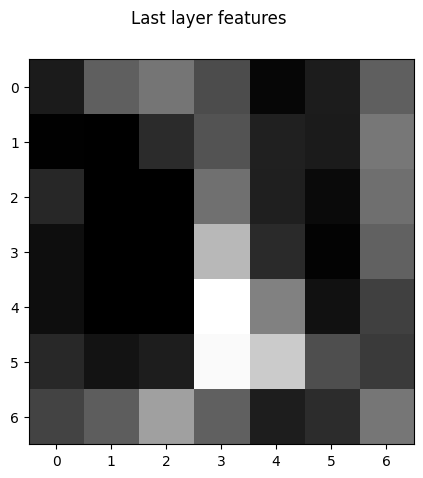

In [81]:
# plot the features
def plot_features(features, title):
    # in the cnn_block, each layer's output channel is the same as the input channel, which is 1
    plt.figure(figsize=(10, 5))
    plt.imshow(features[0][0].cpu().detach().numpy(), cmap='gray')
    plt.suptitle(title)
    plt.show()

plot_features(features_first, 'First layer features')
plot_features(features_last, 'Last layer features')